<a href="https://colab.research.google.com/github/herysedra/ady_cov/blob/master/scr/modely_RP/Jer_toam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!pip install pynverse

  Created wheel for pynverse: filename=pynverse-0.1.4.4-cp36-none-any.whl size=6350 sha256=ad2100623a1de2f48c8f6ddf79b728fa93903b597f98ad5da318135d77e16089
  Stored in directory: /root/.cache/pip/wheels/80/ab/86/ec93f37613f012ba3e65c2bbd67e5c54cbc00d237574100c24
Successfully built pynverse


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

import datetime
import time
from datetime import date

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

from numpy import log,exp
from numpy.random import multinomial
from scipy.stats import uniform, gamma, gengamma, poisson, nbinom, expon
from scipy.integrate import quad


from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from pynverse import inversefunc

tilyvoa = pd.read_csv("/content/drive/My Drive/data/tilyvoa.csv")

mdg_databe = pd.read_csv("/content/drive/My Drive/data/databe mdg.csv")

#tilyvoa.set_index('Daty', inplace=True)

tilyvoafar = tilyvoa.groupby('Faritra')

tilyvoamdg = tilyvoafar.get_group('Madagasikara')
tilyvoamdg.set_index('Daty', inplace=True)
tilyvoamdg.index = pd.to_datetime(tilyvoamdg.index)

tilyvoatoa = tilyvoafar.get_group('Toamasina')
tilyvoatoa.set_index('Daty', inplace=True)
tilyvoatoa.index = pd.to_datetime(tilyvoatoa.index)


path_to_save = '/content/drive/My Drive/sary/'
path_data = '/content/drive/My Drive/data/'

In [ ]:
# Voa vaovao (observed incidence)
Ivaotoa = tilyvoatoa['Voatomb']

dIvao = pd.DataFrame(data =Ivaotoa)

# Hoan'ny taha sorisoritry ny fifindrana (infectioness profile distribution)

daty_data_manom = datetime.date(2020,6,1)
daty_data_mifar = datetime.date(2020,6,27)

datyt = daty_data_mifar 

format_date = lambda date_py: '{}-{}-{}'.format(date_py.year, date_py.month, date_py.day)

# Discretization of the serial interval distribution

#Tombana mialoha (prior distributions)
#si_sh = 1/(0.62**2) # Report 13
#si_sc = 6.5/si_sh

si_sh = (6.48**2)/(3.83**2) # Planning tool: Short-term forecasts
si_sc = 6.48/si_sh

def discr_si(t):
  if t == 0:
    discrsi = 0
  elif t == 1:
    discrsi = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)
  else:
    discrsi = gengamma.cdf(t+1/2, si_sh, 1, loc = 0, scale = si_sc) - gengamma.cdf(t-1/2, si_sh, 1, loc = 0, scale = si_sc)
  return discrsi

#discr_si1 = gengamma.cdf(3/2, si_sh, 1, loc = 0, scale = si_sc)

# 1/ The total incidence over a generic window (t-k+1,t)
# Ireh(t,k) = sum(i = 0 to k-1) Ivao(t - i))

def Ireh(t,k):
  Irehv = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  else:
    for i in range(k):
      Irehv = Irehv + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]
  return Irehv

# 2/ Tool to compute the total infectiousness over a generic window (t-k+1,t)
# Isi(t,k) = sum(i=0 to k-1) Ivao(t - i)*discr_si(i)

# The definition of Isi(t,k) does not include the term Ivao(t) for i = 0 (because discr_si(0) =0) 
# so we can start the sum from i = 1; but it includes the last term Ivao(t - k + 1)*discr_si(k - 1) for i = k-1. 

def Isi(t,k):
  Ivaosi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range(1, (t - daty_data_manom).days + 1):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  else:
    for i in range(1, k):
      Ivaosi = Ivaosi + dIvao['Voatomb'].loc[format_date(t - datetime.timedelta(days = i))]*discr_si(i)
  return Ivaosi

# The total infectiousness before t

# lsi(t) := sum(i=0 to t-1) Ivao(t - i)*discr_si(i)

def lsi(t):
  return Isi(t, (t - daty_data_manom).days +1)

  # for checking, take for example t = daty_data_manom + datetime.timedelta(days = 3)

# 3/ The sum of total infectiousness before t over a generic window (t-k+1,t)
# tlsi(t) := sum(i=t-k+1 to t)lsi(i)

def tlsi(t,k):
  tlsi = 0
  if k - 1 > (t - daty_data_manom).days:
    for i in range((t - daty_data_manom).days + 1):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  else:
    for i in range(k):
      tlsi = tlsi + lsi(t - datetime.timedelta(days = i))
  return tlsi

# 4/ The shape parameters of the posterior predictive negative binomial of I(t+1)
# pnb(t,k) = lsi(t+1)*Gamma_post_scale(R(t,k))/(1 + lsi(t+1)*Gamma_post_scale(R(t,k)))

def pnb(t,k):
  return lsi(t+datetime.timedelta(days = 1))/(1/si_sc + tlsi(t,k) + lsi(t+datetime.timedelta(days = 1)))

# pnb(t,k) dia ny taha herjika hoan'ny NB hoan'ny I(t+1).

# 5/ Use the pmf of the posterior predictive negative binomial to compute
# each additive contribution at time s then for-loop for s in the time interval

def lpr(t,k):
  return -np.log(nbinom.pmf(dIvao['Voatomb'].loc[format_date(t + datetime.timedelta(days = 1))], si_sh + Ireh(t,k), pnb(t,k)))


In [ ]:
# 6/ Computation of the Accumulated Predictive Error

# APE9_part1 

# for i in range(8):
# t = t_mif - i - 1
# k = 9

APEt91 = []
Prt91 = []

APE91 = 0

for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2) - 1):
  t = daty_data_mifar - datetime.timedelta(days = i+1) 
  k = round(((daty_data_mifar - daty_data_manom).days + 1)/2)
  APE91 = APE91 + lpr(t,k)
  APEt91.append((lpr(t,k),t))
  Prt91.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE91 =', APE91)
print('APEt91 =', APEt91)
print('Prt91 =', Prt91)

# APE9_part2 

# for i in range(9):
# t = t_mif - 1 - 9 + 1 - i
# k = t_mif - t - 2*i
APEt92 = []
Prt92 = []

APE92 = 0
for i in range(round(((daty_data_mifar - daty_data_manom).days + 1)/2)-1):
  t = daty_data_mifar - datetime.timedelta(days = 1) - datetime.timedelta(days = ((daty_data_mifar - daty_data_manom).days + 1)/2) + datetime.timedelta(days = 1) - datetime.timedelta(days = i)
  k = (daty_data_mifar - t - datetime.timedelta(days = 2*i)).days
  APE92 = APE92 + lpr(t,k) 
  APEt92.append((lpr(t,k) ,t,k))
  Prt92.append(expon.pdf(lpr(t,k)))

print('For k = 9, APE92 =', APE92)
print('APEt92=', APEt92)
print('Prt92=', Prt92)

# For t_man such that Ivao(t_man) = Ivao(t_man + 1) = 0, lsi(t_man + 1) = tlsi(t_man + 1, 2) = Ireh(t_man + 1, 2) = 0
# so that pnb(t_man + 1, 2) = 0 and 

For k = 9, APE91 = 6606.181343211844
APEt91 = [(624.8192813000651, datetime.date(2020, 6, 7)), (629.1681380477379, datetime.date(2020, 6, 6)), (566.4794028693617, datetime.date(2020, 6, 5)), (634.8862660701682, datetime.date(2020, 6, 4)), (598.900820116142, datetime.date(2020, 6, 3)), (578.4118966619181, datetime.date(2020, 6, 2)), (674.6707826209289, datetime.date(2020, 6, 1)), (636.7111809120225, datetime.date(2020, 5, 31)), (672.8872541887763, datetime.date(2020, 5, 30)), (553.0620231386806, datetime.date(2020, 5, 29)), (436.18429728604406, datetime.date(2020, 5, 28))]
Prt91 = [4.409952834669763e-272, 5.69835440699117e-274, 9.574612843668175e-247, 1.8723973145022163e-276, 7.955703997054599e-261, 6.29368514384857e-252, 9.867383473068359e-294, 3.018891911480678e-277, 5.871898809675788e-293, 6.430062594006855e-241, 3.6945929384520903e-190]
For k = 9, APE92 = 1675.4528943833834
APEt92= [(400.09631303681067, datetime.date(2020, 5, 27), 12), (355.91092919975705, datetime.date(2020, 5, 26)

In [ ]:
# APEk part 1 for k =/= 9

# for i in range(t_mif - t_man -j)

APEk1 = []
#APEt21 = []
for j in range(2,9):
  APEj1 = 0
  for i in range(round(((daty_data_mifar - daty_data_manom).days) - j)):
    t = daty_data_mifar - datetime.timedelta(days = i+1) 
    k = j
    APEj1 = APEj1 + lpr(t,k)
   # APEt21.append(lpr(t,k))
  APEk1.append(APEj1)

print('APEk1 =', APEk1)
#print('APEt21 =', APEt21)

# APEk part 2 for k =/= 9

Prk2 = []

APEk2 = []

for j in range(2,9):
  APEj2 = 0
  for i in range(j-1):
    t = daty_data_manom + datetime.timedelta(days = j - i - 1)
    k = j - i
    APEj2 = APEj2 + lpr(t,k)
  APEk2.append(APEj2)

print('APEk2 =', APEk2)

APEk1 = [425.1421537905662, 993.6798060776907, 1725.3793774657547, 2483.193940298328, 3237.4245435977914, 4000.5797285680887, 4673.166551475902]
APEk2 = [2.60451070788479, 26.003881203771556, 31.207179348247905, 68.98579759930296, 122.47354577125239, 214.61176297608748, 392.74730446558715]


In [ ]:
# APEk for k = 2,...,8

APEk = [x + y for x, y in zip(APEk1, APEk2)]

# APE9
APE9 = APE91 + APE92

APE = APEk + [APE9]
kk = APE.index(min(APE)) +2
print('APE9 =', APE9)
print('APEk =', APEk)
print('APE =', APE)
print(kk)


APE9 = 8281.634237595228
APEk = [427.746664498451, 1019.6836872814623, 1756.5865568140025, 2552.179737897631, 3359.8980893690436, 4215.191491544177, 5065.91385594149]
APE = [427.746664498451, 1019.6836872814623, 1756.5865568140025, 2552.179737897631, 3359.8980893690436, 4215.191491544177, 5065.91385594149, 8281.634237595228]
2


In [ ]:
#shape
def func_sh(t):
    def Rtpsand_sh(a):
      return a + Ireh(t,kk)
    return Rtpsand_sh

# Scale
def func_sc(t):
    def Rtpsand_sc(b):
      return 1/(1/b + tlsi(t,kk))
    return Rtpsand_sc


def funcsh_inv(t):
    def sh_invex(x):
      return (x + Ireh(t,kk))/x
    return inversefunc(sh_invex, domain=[1e-11, 1e+11])

def Rt_salan(t):
    ffunc_sh = func_sh(t)
    ffunc_sc = func_sc(t)
    ffuncsh_inv = funcsh_inv(t)
    return ffuncsh_inv(1/ffunc_sc(1))

# The 95th and 5th percentiles of Rt

def perc75(t):
    return gengamma.ppf(0.75, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def perc25(t):
    return gengamma.ppf(0.25, func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1))

def Rtps_sal(t):
  return dIvao['Voatomb'].loc[format_date(t)]/lsi(t)

In [ ]:
# Plotting everything except the first 7 days

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_lst = []

data_Rt_lst = []

for i in range(round(((daty_data_mifar - daty_data_manom).days) -7)):
  t = daty_data_manom + datetime.timedelta(days = i+1 +7)
  data_amboar = [gengamma.rvs( func_sh(t)(Rt_salan(t)), 1, loc = 0, scale = func_sc(t)(1)) for j in range(100)]
  daty_lst.append(formatf_date(t))
  data_Rt_lst.append(data_amboar)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


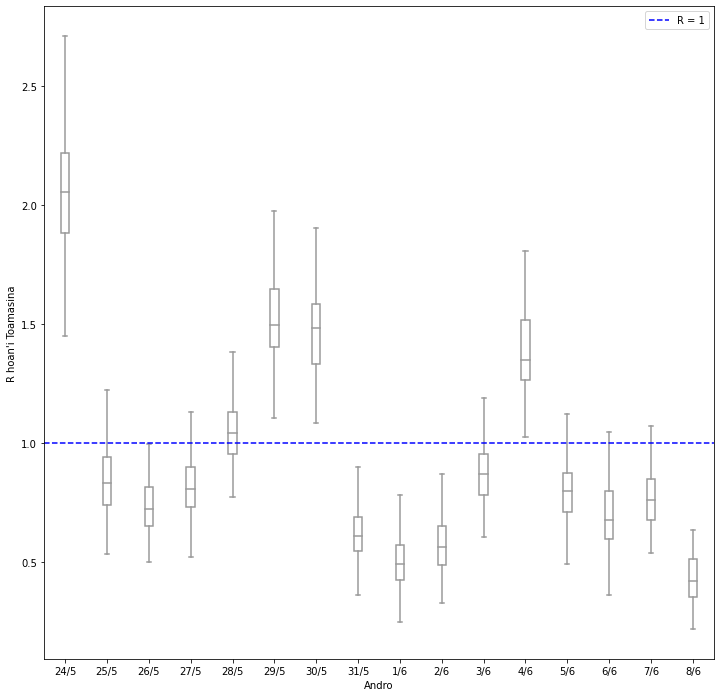

In [ ]:
# Plotting everything except the first 7 days


fig, ax = plt.subplots(figsize=(12, 12))

sns.boxplot(daty_lst, data_Rt_lst, color='white', width=0.2, showfliers=False, ax=ax)
ax.axhline(y=1, color='b', linestyle='dashed', label ="R = 1")

ax.set(xlabel ='Andro', ylabel = "R hoan'i Toamasina")
ax.legend(loc= 'best')

plt.savefig(path_to_save+'Rt24686_toam.eps')
plt.savefig(path_to_save+'Rt24686_toam.png')

plt.show()

## Herinandro voalohany

In [ ]:
daty_ambaj = datetime.date(2020,6,15)
daty_amboj = datetime.date(2020,6,18)

daty_data_mifarj = datetime.date(2020,6,13)

In [ ]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-06-15 : 0.3222396723861093
75%-kartily R : : 0.38065987631423304
25%-kartily R : 0.25355537202572015
Tombana ambony: R 2020-06-18 : 0.7349898825464655
75%-kartily R : : 0.8388151813913842
25%-kartily R : 0.6176891532015611


### Manakaiky avy aty ambany

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


### Manakaiky avy aty ambony

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_ambo_hitsiny = 0.1
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


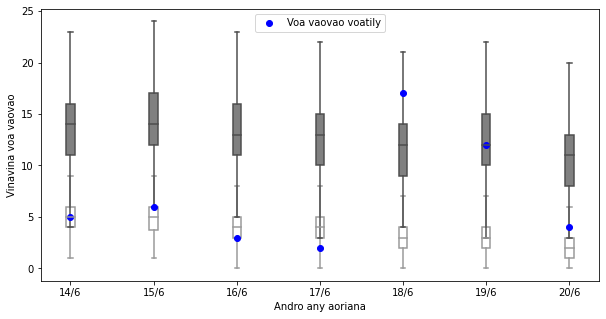

In [ ]:
# Plotting

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro any aoriana', ylabel="Vinavina voa vaovao")

plt.legend(loc= 'upper center')

plt.savefig(path_to_save+'Iv146206j_toam.eps')
plt.savefig(path_to_save+'Iv146206j_toam.png')

plt.show()

## Herinandro faharoa

In [ ]:
daty_ambaj = datetime.date(2020,6,15)
daty_amboj = datetime.date(2020,6,27)

daty_data_mifarj = datetime.date(2020,6,20)

In [ ]:
daty_oh1 = daty_ambaj

print("Tombana ambany: R ",daty_oh1,':',  Rt_salan(daty_oh1))
print("75%-kartily R :",':', perc75(daty_oh1))
print("25%-kartily R :", perc25(daty_oh1))

daty_oh2 = daty_amboj

print("Tombana ambony: R", daty_oh2,':', Rt_salan(daty_oh2))
print("75%-kartily R :",':', perc75(daty_oh2))
print("25%-kartily R :", perc25(daty_oh2))


Tombana ambany: R  2020-06-15 : 0.3222396723861093
75%-kartily R : : 0.38065987631423304
25%-kartily R : 0.25355537202572015
Tombana ambony: R 2020-06-27 : 2.0877074975329295
75%-kartily R : : 2.3104428672959663
25%-kartily R : 1.8439992083446186


### Manakaiky avy aty ambany

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_amba_hitsiny = 0
Rt_vinaj = Rt_salan(daty_ambaj) + Rt_amba_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_baj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_baj.append(data_amboar)


### Manakaiky avy aty ambony

In [ ]:
# Computing Ivao(daty_mifarj + i) for i in range(1,8)

daty_m1j = daty_data_mifarj + datetime.timedelta(days = 1)

Rt_ambo_hitsiny = 0
Rt_vinaj = Rt_salan(daty_amboj) + Rt_ambo_hitsiny

Iv = int(Rt_vinaj*lsi(daty_m1j))

dIvao.loc[pd.to_datetime(daty_m1j)] =[Iv]

for i in range(1,8):
 tj = daty_m1j + datetime.timedelta(days = i)
 Ivv = int(Rt_vinaj*lsi(tj))
 dIvao.loc[pd.to_datetime(tj)] = [Ivv]

In [ ]:
# Sampling

np.random.seed(12345)

formatf_date = lambda date_py: '{}/{}'.format(date_py.day, str(date_py.month)[0:1])

daty_j_lst = []

data_boj = []


for i in range(1,8):
  t = daty_data_mifarj + datetime.timedelta(days = i)
  daty = formatf_date(t)
  datyy = format_date(t)
  data_amboar = [ poisson.rvs(dIvao.loc[datyy]) for j in range(600)]
  daty_j_lst.append(daty)
  data_boj.append(data_amboar)


### Sary

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


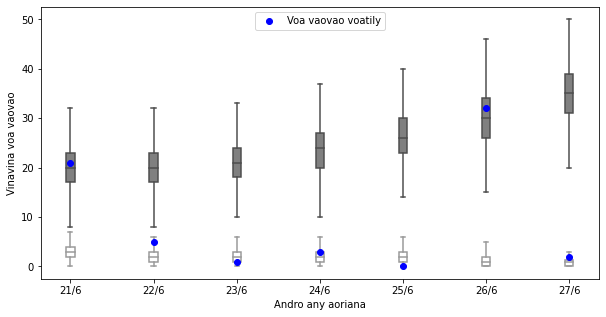

In [ ]:
# Plotting

fig, ax = plt.subplots(figsize=(10,5))
box = sns.boxplot(daty_j_lst, data_baj, color='white', width=0.1, showfliers=False, ax=ax)
box = sns.boxplot(daty_j_lst, data_boj, color='grey', width=0.1, showfliers=False, ax=ax)
ax.plot(daty_j_lst, dIvao.loc[pd.to_datetime(daty_m1j):pd.to_datetime(daty_m1j + datetime.timedelta(days = 6))], marker ="o",ls = 'None', color='blue',label="Voa vaovao voatily")
ax.set(xlabel = 'Andro any aoriana', ylabel="Vinavina voa vaovao")

plt.legend(loc= 'upper center')

plt.savefig(path_to_save+'Iv216276j_toam.eps')
plt.savefig(path_to_save+'Iv216276j_toam.png')

plt.show()